# Allen Institute
## 04-1_hyperparams
---
## Dataset
- `../data/m1_10x_ml/ref_top1000_log.pkl`

## WorkFlow
- Hyperparameter tuning
 
 **Notes)**
 
 if kernel dies during running codes, you can ommit completed sections indexed if alphabets

In [1]:
import json
import os
from typing import NamedTuple, Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import seaborn as sns

from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import label_binarize
from tqdm.notebook import tqdm

from tools.figure import boxplot, cns_markers, fig_kwarg
from tools.random import iterative_seed

In [35]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_ml/train_top1000_log.pkl"
    )
    label: pd.core.frame.DataFrame = pd.read_csv(
        "../data/m1_10x_meta/metadata.csv", index_col=0
    )
    n: int = 5
    test_data: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_ml/test_top1000_log.pkl"
    )
    save_dir: str = "../out/m1_10x/04_hyperparams"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [37]:
conf = Config(save_file=True)

In [5]:
os.makedirs(conf.save_dir, exist_ok=True)

In [6]:
label_dict = {v: i for i, v in enumerate(conf.label.class_label.unique())}

---
## Learning Hyperparameters
- Cross validation: Stratified Group K Fold

In [7]:
label = pd.Series(
    [label_dict[v] for v in conf.label.class_label.loc[conf.data.index]],
    index = conf.data.index
)

In [8]:
params = dict(
    objective="multiclass", metric="multi_logloss",
    num_class=len(conf.label.class_label.unique()),
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

optuna_seed = iterative_seed(n_iter=conf.n, seed=0)

In [9]:
l_model = [lgb.LightGBMTuner] * conf.n

for idx, seed, (i, model) in zip(
    StratifiedGroupKFold(
        n_splits=conf.n,
        shuffle=True,
        random_state=0
    ).split(conf.data, label, conf.label.loc[conf.data.index].subclass_label),
    optuna_seed,
    enumerate(l_model)
):
    train = lgb.Dataset(conf.data.iloc[idx[0], :], label[idx[0]])
    valid = lgb.Dataset(conf.data.iloc[idx[1], :], label[idx[1]], reference=train)
    l_model[i] = model(
        params,
        train,
        valid_sets=valid,
        verbose_eval=False,
        verbosity=-1,
        optuna_seed=seed,
        callbacks=[early_stopping(50), log_evaluation(1000)]
    )
    l_model[i].run()

[I 2022-08-30 04:47:23,300] A new study created in memory with name: no-name-120e5e16-b127-4ce6-a268-0cf4efd62f89
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.169728:  14%|#4        | 1/7 [00:07<00:46,  7.73s/it]

Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.169728


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.158648:  29%|##8       | 2/7 [00:13<00:33,  6.63s/it]

Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.158648


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.147146:  43%|####2     | 3/7 [00:17<00:21,  5.32s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.147146


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.147146:  57%|#####7    | 4/7 [00:24<00:17,  5.85s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.147146


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.147146:  71%|#######1  | 5/7 [00:28<00:10,  5.38s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.147146


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.147146:  86%|########5 | 6/7 [00:33<00:05,  5.27s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.147146


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.147146: 100%|##########| 7/7 [00:40<00:00,  5.81s/it]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.147146


num_leaves, val_score: 0.147146:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146338:   5%|5         | 1/20 [00:07<02:13,  7.03s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146338


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  10%|#         | 2/20 [00:18<02:52,  9.59s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  15%|#5        | 3/20 [00:36<03:46, 13.30s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  20%|##        | 4/20 [00:41<02:41, 10.08s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  25%|##5       | 5/20 [00:58<03:12, 12.83s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  30%|###       | 6/20 [01:18<03:33, 15.26s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146169:  35%|###5      | 7/20 [01:25<02:42, 12.54s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.146169


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  40%|####      | 8/20 [01:34<02:16, 11.37s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  45%|####5     | 9/20 [01:44<02:00, 10.95s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  50%|#####     | 10/20 [02:05<02:20, 14.01s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  55%|#####5    | 11/20 [02:08<01:34, 10.48s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  60%|######    | 12/20 [02:21<01:30, 11.33s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  65%|######5   | 13/20 [02:31<01:16, 10.93s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  70%|#######   | 14/20 [02:47<01:14, 12.40s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  75%|#######5  | 15/20 [03:01<01:04, 12.94s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.146150:  80%|########  | 16/20 [03:09<00:45, 11.45s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.14615


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.145783:  85%|########5 | 17/20 [03:12<00:26,  8.84s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.145783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.145783:  90%|######### | 18/20 [03:28<00:21, 10.97s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.145783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.145783:  95%|#########5| 19/20 [03:45<00:12, 12.86s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.145783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.145783: 100%|##########| 20/20 [04:02<00:00, 12.12s/it]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.145783


bagging, val_score: 0.145783:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.140654:  10%|#         | 1/10 [00:02<00:24,  2.68s/it]

Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.140654


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.140654:  20%|##        | 2/10 [00:05<00:23,  2.89s/it]

Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.140654


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.140654:  30%|###       | 3/10 [00:08<00:21,  3.04s/it]

Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.140654


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.139034:  40%|####      | 4/10 [00:11<00:18,  3.04s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.139034


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219:  50%|#####     | 5/10 [00:14<00:15,  3.00s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219:  60%|######    | 6/10 [00:17<00:11,  2.95s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219:  70%|#######   | 7/10 [00:20<00:08,  2.90s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219:  80%|########  | 8/10 [00:23<00:05,  2.83s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219:  90%|######### | 9/10 [00:26<00:02,  2.82s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.137219: 100%|##########| 10/10 [00:28<00:00,  2.88s/it]


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


feature_fraction_stage2, val_score: 0.137219:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.137219:  33%|###3      | 1/3 [00:03<00:06,  3.04s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.137219


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.135792:  67%|######6   | 2/3 [00:05<00:02,  2.83s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.135792


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.135792: 100%|##########| 3/3 [00:08<00:00,  2.91s/it]


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.135792


regularization_factors, val_score: 0.135792:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.134703:   5%|5         | 1/20 [00:02<00:40,  2.15s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.134703


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.134703:  10%|#         | 2/20 [00:03<00:29,  1.62s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.134703


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.134703:  15%|#5        | 3/20 [00:04<00:24,  1.46s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.134703


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133544:  20%|##        | 4/20 [00:07<00:30,  1.88s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.133544


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133544:  25%|##5       | 5/20 [00:08<00:27,  1.84s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.133544


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133077:  30%|###       | 6/20 [00:10<00:24,  1.76s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.133077


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133077:  35%|###5      | 7/20 [00:11<00:20,  1.56s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.133077


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133077:  40%|####      | 8/20 [00:13<00:18,  1.53s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.133077


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.133077:  45%|####5     | 9/20 [00:14<00:15,  1.42s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.133077


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132987:  50%|#####     | 10/20 [00:16<00:15,  1.51s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.132987


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132987:  55%|#####5    | 11/20 [00:18<00:17,  1.90s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.132987


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132987:  60%|######    | 12/20 [00:21<00:17,  2.19s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.132987


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132987:  65%|######5   | 13/20 [00:24<00:16,  2.38s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.132987


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132987:  70%|#######   | 14/20 [00:26<00:12,  2.14s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.132987


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337:  75%|#######5  | 15/20 [00:28<00:10,  2.12s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337:  80%|########  | 16/20 [00:30<00:08,  2.09s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337:  85%|########5 | 17/20 [00:32<00:06,  2.10s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337:  90%|######### | 18/20 [00:34<00:04,  2.11s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337:  95%|#########5| 19/20 [00:36<00:02,  2.23s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.132337: 100%|##########| 20/20 [00:38<00:00,  1.93s/it]


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


min_data_in_leaf, val_score: 0.132337:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.132337:  20%|##        | 1/5 [00:02<00:08,  2.13s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.132337:  40%|####      | 2/5 [00:04<00:05,  1.97s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.132337:  60%|######    | 3/5 [00:06<00:04,  2.07s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.132337:  80%|########  | 4/5 [00:08<00:02,  2.01s/it]

Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.132337: 100%|##########| 5/5 [00:10<00:00,  2.05s/it]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.132337


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.012277:  14%|#4        | 1/7 [00:07<00:47,  7.95s/it]

Did not meet early stopping. Best iteration is:
[72]	valid_0's multi_logloss: 0.0122769


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008399:  29%|##8       | 2/7 [00:13<00:32,  6.53s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00839897


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008143:  43%|####2     | 3/7 [00:18<00:23,  5.77s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008143:  57%|#####7    | 4/7 [00:25<00:19,  6.36s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008143:  71%|#######1  | 5/7 [00:35<00:14,  7.48s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008143:  86%|########5 | 6/7 [00:43<00:07,  7.80s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.008143: 100%|##########| 7/7 [00:50<00:00,  7.17s/it]


Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


num_leaves, val_score: 0.008143:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.008143:   5%|5         | 1/20 [00:19<06:17, 19.85s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.008143:  10%|#         | 2/20 [00:25<03:30, 11.68s/it]

Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.00814305


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  15%|#5        | 3/20 [00:49<04:54, 17.32s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  20%|##        | 4/20 [01:06<04:30, 16.90s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  25%|##5       | 5/20 [01:23<04:17, 17.15s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  30%|###       | 6/20 [01:38<03:47, 16.26s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  35%|###5      | 7/20 [01:41<02:36, 12.05s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  40%|####      | 8/20 [01:50<02:12, 11.05s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  45%|####5     | 9/20 [02:16<02:53, 15.79s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  50%|#####     | 10/20 [02:29<02:28, 14.88s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  55%|#####5    | 11/20 [02:51<02:34, 17.16s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  60%|######    | 12/20 [03:12<02:26, 18.32s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


num_leaves, val_score: 0.007956:  65%|######5   | 13/20 [03:38<02:23, 20.47s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  70%|#######   | 14/20 [03:59<02:03, 20.56s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  75%|#######5  | 15/20 [04:22<01:47, 21.45s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  80%|########  | 16/20 [04:38<01:19, 19.87s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  85%|########5 | 17/20 [04:57<00:58, 19.54s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007956:  90%|######### | 18/20 [05:17<00:39, 19.75s/it]

Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.00795644


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007726:  95%|#########5| 19/20 [05:28<00:16, 16.93s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.00772614


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007726: 100%|##########| 20/20 [05:38<00:00, 16.92s/it]


Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.00772614


bagging, val_score: 0.007726:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.007726:  10%|#         | 1/10 [00:12<01:49, 12.16s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.00772614


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.007726:  20%|##        | 2/10 [00:24<01:40, 12.52s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.00772614


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.007726:  30%|###       | 3/10 [00:37<01:26, 12.34s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.00772614


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  40%|####      | 4/10 [00:47<01:09, 11.64s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  50%|#####     | 5/10 [00:59<00:58, 11.69s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  60%|######    | 6/10 [01:09<00:44, 11.15s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  70%|#######   | 7/10 [01:20<00:33, 11.06s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  80%|########  | 8/10 [01:32<00:22, 11.43s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295:  90%|######### | 9/10 [01:43<00:11, 11.32s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.006295: 100%|##########| 10/10 [01:55<00:00, 11.52s/it]


Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00629548


feature_fraction_stage2, val_score: 0.006295:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.005240:  33%|###3      | 1/3 [00:12<00:24, 12.12s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.005240:  67%|######6   | 2/3 [00:23<00:11, 11.97s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.005240: 100%|##########| 3/3 [00:35<00:00, 11.85s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


regularization_factors, val_score: 0.005240:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:   5%|5         | 1/20 [00:02<00:43,  2.31s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  10%|#         | 2/20 [00:04<00:37,  2.08s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  15%|#5        | 3/20 [00:07<00:46,  2.73s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  20%|##        | 4/20 [00:15<01:13,  4.62s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  25%|##5       | 5/20 [00:17<00:55,  3.72s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  30%|###       | 6/20 [00:19<00:43,  3.11s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  35%|###5      | 7/20 [00:21<00:35,  2.69s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  40%|####      | 8/20 [00:23<00:29,  2.48s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  45%|####5     | 9/20 [00:29<00:39,  3.55s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  50%|#####     | 10/20 [00:30<00:30,  3.02s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.005240:  55%|#####5    | 11/20 [00:34<00:28,  3.12s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0052402


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004940:  60%|######    | 12/20 [00:36<00:23,  2.91s/it]

Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.00493993


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004940:  65%|######5   | 13/20 [00:39<00:20,  2.86s/it]

Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.00493993


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  70%|#######   | 14/20 [00:42<00:17,  2.86s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  75%|#######5  | 15/20 [00:44<00:13,  2.74s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  80%|########  | 16/20 [00:47<00:10,  2.75s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  85%|########5 | 17/20 [00:50<00:08,  2.72s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  90%|######### | 18/20 [00:52<00:05,  2.59s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742:  95%|#########5| 19/20 [00:55<00:02,  2.73s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004742: 100%|##########| 20/20 [00:58<00:00,  2.93s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


min_data_in_leaf, val_score: 0.004742:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004742:  20%|##        | 1/5 [00:03<00:14,  3.52s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004742:  40%|####      | 2/5 [00:05<00:08,  2.88s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004742:  60%|######    | 3/5 [00:08<00:05,  2.76s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00474218


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.003965:  80%|########  | 4/5 [00:11<00:02,  2.89s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00396486


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.003965: 100%|##########| 5/5 [00:14<00:00,  2.93s/it]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00396486


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.016621:  14%|#4        | 1/7 [00:07<00:47,  7.98s/it]

Did not meet early stopping. Best iteration is:
[85]	valid_0's multi_logloss: 0.0166207


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767:  29%|##8       | 2/7 [00:14<00:34,  6.92s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767:  43%|####2     | 3/7 [00:23<00:31,  7.96s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767:  57%|#####7    | 4/7 [00:34<00:27,  9.13s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767:  71%|#######1  | 5/7 [00:45<00:19,  9.75s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767:  86%|########5 | 6/7 [00:52<00:08,  8.87s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.007767: 100%|##########| 7/7 [01:02<00:00,  8.92s/it]


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


num_leaves, val_score: 0.007767:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007767:   5%|5         | 1/20 [00:01<00:34,  1.83s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007767:  10%|#         | 2/20 [00:07<01:11,  3.96s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007767:  15%|#5        | 3/20 [00:32<03:51, 13.65s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00776656


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007113:  20%|##        | 4/20 [00:52<04:21, 16.35s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.00711335


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  25%|##5       | 5/20 [00:55<02:53, 11.55s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  30%|###       | 6/20 [01:07<02:41, 11.57s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  35%|###5      | 7/20 [01:21<02:38, 12.17s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  40%|####      | 8/20 [01:42<03:03, 15.29s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  45%|####5     | 9/20 [01:54<02:35, 14.16s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  50%|#####     | 10/20 [02:10<02:25, 14.53s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  55%|#####5    | 11/20 [02:17<01:52, 12.50s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.007038:  60%|######    | 12/20 [02:28<01:34, 11.81s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00703783


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  65%|######5   | 13/20 [02:37<01:18, 11.18s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  70%|#######   | 14/20 [02:40<00:51,  8.57s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  75%|#######5  | 15/20 [02:48<00:42,  8.48s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  80%|########  | 16/20 [03:04<00:42, 10.57s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  85%|########5 | 17/20 [03:10<00:28,  9.43s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  90%|######### | 18/20 [03:17<00:17,  8.60s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203:  95%|#########5| 19/20 [03:31<00:10, 10.34s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.006203: 100%|##########| 20/20 [03:51<00:00, 11.57s/it]


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00620329


bagging, val_score: 0.006203:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.003373:  10%|#         | 1/10 [00:07<01:11,  7.96s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00337318


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.003373:  20%|##        | 2/10 [00:16<01:05,  8.17s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00337318


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.003067:  30%|###       | 3/10 [00:24<00:57,  8.16s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00306696


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.003067:  40%|####      | 4/10 [00:32<00:48,  8.13s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00306696


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.003067:  50%|#####     | 5/10 [00:41<00:42,  8.46s/it]

Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.00306696


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.002199:  60%|######    | 6/10 [00:50<00:35,  8.76s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.002199:  70%|#######   | 7/10 [01:01<00:28,  9.34s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.002199:  80%|########  | 8/10 [01:10<00:18,  9.16s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.002199:  90%|######### | 9/10 [01:20<00:09,  9.42s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.002199: 100%|##########| 10/10 [01:29<00:00,  8.92s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


feature_fraction_stage2, val_score: 0.002199:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.002199:  33%|###3      | 1/3 [00:12<00:24, 12.40s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.002199:  67%|######6   | 2/3 [00:21<00:10, 10.55s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.002199: 100%|##########| 3/3 [00:32<00:00, 10.89s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00219866


regularization_factors, val_score: 0.002199:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:   5%|5         | 1/20 [00:08<02:38,  8.36s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  10%|#         | 2/20 [00:10<01:23,  4.62s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  15%|#5        | 3/20 [00:16<01:33,  5.49s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  20%|##        | 4/20 [00:19<01:11,  4.50s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  25%|##5       | 5/20 [00:24<01:06,  4.41s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  30%|###       | 6/20 [00:27<00:57,  4.08s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  35%|###5      | 7/20 [00:30<00:47,  3.65s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  40%|####      | 8/20 [00:33<00:41,  3.48s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  45%|####5     | 9/20 [00:35<00:34,  3.11s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  50%|#####     | 10/20 [00:39<00:33,  3.31s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  55%|#####5    | 11/20 [00:47<00:43,  4.87s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  60%|######    | 12/20 [00:49<00:31,  3.97s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  65%|######5   | 13/20 [00:52<00:24,  3.44s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  70%|#######   | 14/20 [00:54<00:18,  3.09s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  75%|#######5  | 15/20 [00:56<00:14,  2.91s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  80%|########  | 16/20 [00:59<00:10,  2.69s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  85%|########5 | 17/20 [01:02<00:08,  2.80s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  90%|######### | 18/20 [01:04<00:05,  2.72s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067:  95%|#########5| 19/20 [01:06<00:02,  2.59s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.002067: 100%|##########| 20/20 [01:10<00:00,  3.51s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


min_data_in_leaf, val_score: 0.002067:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.002067:  20%|##        | 1/5 [00:05<00:23,  5.90s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.002067:  40%|####      | 2/5 [00:13<00:20,  6.74s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.002067:  60%|######    | 3/5 [00:21<00:14,  7.40s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.002067:  80%|########  | 4/5 [00:29<00:07,  7.55s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.002067: 100%|##########| 5/5 [00:35<00:00,  7.04s/it]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00206726


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.022381:  14%|#4        | 1/7 [00:07<00:47,  7.87s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0223811


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.022381:  29%|##8       | 2/7 [00:19<00:51, 10.37s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0223811


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.022381:  43%|####2     | 3/7 [00:31<00:43, 10.75s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0223811


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.022381:  57%|#####7    | 4/7 [00:39<00:29,  9.86s/it]

Did not meet early stopping. Best iteration is:
[64]	valid_0's multi_logloss: 0.0223811


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.019694:  71%|#######1  | 5/7 [00:46<00:17,  8.64s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.019694:  86%|########5 | 6/7 [00:57<00:09,  9.38s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.019694: 100%|##########| 7/7 [01:03<00:00,  9.07s/it]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


num_leaves, val_score: 0.019694:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019694:   5%|5         | 1/20 [00:08<02:36,  8.22s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019694:  10%|#         | 2/20 [00:21<03:19, 11.11s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019694:  15%|#5        | 3/20 [00:40<04:08, 14.63s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019694:  20%|##        | 4/20 [01:05<05:03, 18.98s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0196935


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  25%|##5       | 5/20 [01:10<03:26, 13.79s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  30%|###       | 6/20 [01:43<04:44, 20.33s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  35%|###5      | 7/20 [01:50<03:27, 15.96s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  40%|####      | 8/20 [02:05<03:08, 15.71s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  45%|####5     | 9/20 [02:32<03:29, 19.09s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  50%|#####     | 10/20 [02:58<03:34, 21.48s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  55%|#####5    | 11/20 [03:03<02:26, 16.26s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  60%|######    | 12/20 [03:37<02:52, 21.62s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  65%|######5   | 13/20 [03:58<02:29, 21.41s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  70%|#######   | 14/20 [04:33<02:34, 25.74s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


num_leaves, val_score: 0.019419:  70%|#######   | 14/20 [04:33<02:34, 25.74s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  75%|#######5  | 15/20 [05:02<02:13, 26.68s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  80%|########  | 16/20 [05:15<01:30, 22.53s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  85%|########5 | 17/20 [05:39<01:09, 23.01s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  90%|######### | 18/20 [06:07<00:48, 24.49s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419:  95%|#########5| 19/20 [06:23<00:21, 21.75s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.019419: 100%|##########| 20/20 [06:44<00:00, 20.21s/it]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


bagging, val_score: 0.019419:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  10%|#         | 1/10 [00:05<00:47,  5.30s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  20%|##        | 2/10 [00:10<00:42,  5.27s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  30%|###       | 3/10 [00:15<00:34,  4.99s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  40%|####      | 4/10 [00:20<00:30,  5.03s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  50%|#####     | 5/10 [00:25<00:25,  5.12s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  60%|######    | 6/10 [00:29<00:18,  4.62s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  70%|#######   | 7/10 [00:32<00:12,  4.32s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  80%|########  | 8/10 [00:37<00:08,  4.28s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419:  90%|######### | 9/10 [00:41<00:04,  4.19s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.019419: 100%|##########| 10/10 [00:45<00:00,  4.50s/it]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


feature_fraction_stage2, val_score: 0.019419:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419:  17%|#6        | 1/6 [00:03<00:17,  3.50s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419:  33%|###3      | 2/6 [00:07<00:15,  3.98s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419:  50%|#####     | 3/6 [00:11<00:11,  3.82s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419:  67%|######6   | 4/6 [00:15<00:07,  3.80s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419:  83%|########3 | 5/6 [00:19<00:03,  3.93s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.019419: 100%|##########| 6/6 [00:23<00:00,  3.91s/it]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


regularization_factors, val_score: 0.019419:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:   5%|5         | 1/20 [00:04<01:16,  4.03s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  10%|#         | 2/20 [00:07<01:03,  3.54s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  15%|#5        | 3/20 [00:09<00:52,  3.11s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  20%|##        | 4/20 [00:14<00:58,  3.64s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  25%|##5       | 5/20 [00:17<00:54,  3.60s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  30%|###       | 6/20 [00:21<00:49,  3.53s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  35%|###5      | 7/20 [00:25<00:48,  3.76s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  40%|####      | 8/20 [00:27<00:39,  3.33s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  45%|####5     | 9/20 [00:30<00:34,  3.15s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  50%|#####     | 10/20 [00:34<00:32,  3.28s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  55%|#####5    | 11/20 [00:39<00:35,  3.99s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  60%|######    | 12/20 [00:43<00:31,  3.90s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  65%|######5   | 13/20 [00:47<00:26,  3.85s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  70%|#######   | 14/20 [00:49<00:20,  3.44s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  75%|#######5  | 15/20 [00:53<00:18,  3.67s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.019419:  80%|########  | 16/20 [00:58<00:15,  3.82s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0194193


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.018955:  85%|########5 | 17/20 [01:02<00:12,  4.06s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.018955:  90%|######### | 18/20 [01:07<00:08,  4.41s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.018955:  95%|#########5| 19/20 [01:12<00:04,  4.38s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.018955: 100%|##########| 20/20 [01:17<00:00,  3.88s/it]


Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


min_data_in_leaf, val_score: 0.018955:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.018955:  20%|##        | 1/5 [00:05<00:20,  5.20s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.018955:  40%|####      | 2/5 [00:09<00:14,  4.78s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.018955:  60%|######    | 3/5 [00:13<00:09,  4.54s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.018955:  80%|########  | 4/5 [00:18<00:04,  4.74s/it]

Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.018955: 100%|##########| 5/5 [00:24<00:00,  4.81s/it]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 0.0189551


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.078716:  14%|#4        | 1/7 [00:06<00:39,  6.64s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716:  29%|##8       | 2/7 [00:16<00:43,  8.71s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716:  43%|####2     | 3/7 [00:23<00:31,  7.86s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716:  57%|#####7    | 4/7 [00:31<00:23,  7.74s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716:  71%|#######1  | 5/7 [00:40<00:16,  8.43s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716:  86%|########5 | 6/7 [00:49<00:08,  8.61s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.078716: 100%|##########| 7/7 [01:02<00:00,  8.87s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


num_leaves, val_score: 0.078716:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


num_leaves, val_score: 0.078716:   5%|5         | 1/20 [00:23<07:22, 23.31s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


num_leaves, val_score: 0.078716:  10%|#         | 2/20 [00:46<06:57, 23.21s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.078716:  15%|#5        | 3/20 [01:08<06:26, 22.73s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0787159


num_leaves, val_score: 0.078716:  20%|##        | 4/20 [01:31<06:05, 22.84s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.078118:  25%|##5       | 5/20 [01:56<05:56, 23.74s/it]

Did not meet early stopping. Best iteration is:
[82]	valid_0's multi_logloss: 0.0781179


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.077289:  30%|###       | 6/20 [02:10<04:44, 20.30s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0772893


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.077256:  35%|###5      | 7/20 [02:22<03:49, 17.62s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0772556


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.077256:  40%|####      | 8/20 [02:41<03:34, 17.88s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0772556


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0772556


num_leaves, val_score: 0.077256:  45%|####5     | 9/20 [03:04<03:36, 19.72s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.077256:  50%|#####     | 10/20 [03:18<02:57, 17.80s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0772556


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.076998:  55%|#####5    | 11/20 [03:21<01:59, 13.26s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0769982


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.076998:  60%|######    | 12/20 [03:22<01:17,  9.69s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0769982


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.076998:  65%|######5   | 13/20 [03:27<00:57,  8.22s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0769982


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  70%|#######   | 14/20 [03:29<00:38,  6.35s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  75%|#######5  | 15/20 [03:35<00:31,  6.24s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  80%|########  | 16/20 [03:42<00:25,  6.27s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  85%|########5 | 17/20 [03:55<00:25,  8.57s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  90%|######### | 18/20 [04:12<00:22, 11.10s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976:  95%|#########5| 19/20 [04:27<00:11, 11.99s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.075976: 100%|##########| 20/20 [04:43<00:00, 14.18s/it]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


bagging, val_score: 0.075976:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.075976:  10%|#         | 1/10 [00:01<00:17,  1.95s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0759756


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.067742:  20%|##        | 2/10 [00:04<00:17,  2.21s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0677422


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.067742:  30%|###       | 3/10 [00:07<00:16,  2.41s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0677422


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.065894:  40%|####      | 4/10 [00:09<00:14,  2.48s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.065894


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.065894:  50%|#####     | 5/10 [00:11<00:12,  2.42s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.065894


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.050270:  60%|######    | 6/10 [00:13<00:09,  2.28s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.050270:  70%|#######   | 7/10 [00:16<00:07,  2.39s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.050270:  80%|########  | 8/10 [00:18<00:04,  2.38s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.050270:  90%|######### | 9/10 [00:21<00:02,  2.42s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.050270: 100%|##########| 10/10 [00:23<00:00,  2.40s/it]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


feature_fraction_stage2, val_score: 0.050270:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.050270:  33%|###3      | 1/3 [00:02<00:05,  2.57s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.050270:  67%|######6   | 2/3 [00:05<00:02,  2.56s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.050270: 100%|##########| 3/3 [00:07<00:00,  2.57s/it]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


regularization_factors, val_score: 0.050270:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:   5%|5         | 1/20 [00:02<00:39,  2.07s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  10%|#         | 2/20 [00:04<00:38,  2.13s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  15%|#5        | 3/20 [00:08<00:49,  2.90s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  20%|##        | 4/20 [00:09<00:40,  2.51s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  25%|##5       | 5/20 [00:11<00:32,  2.17s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  30%|###       | 6/20 [00:13<00:28,  2.06s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.050270:  35%|###5      | 7/20 [00:15<00:25,  1.99s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0502699


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  40%|####      | 8/20 [00:17<00:26,  2.19s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  45%|####5     | 9/20 [00:20<00:24,  2.24s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  50%|#####     | 10/20 [00:22<00:21,  2.18s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  55%|#####5    | 11/20 [00:24<00:20,  2.31s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  60%|######    | 12/20 [00:27<00:18,  2.29s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  65%|######5   | 13/20 [00:29<00:15,  2.28s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  70%|#######   | 14/20 [00:31<00:13,  2.26s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  75%|#######5  | 15/20 [00:33<00:11,  2.22s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  80%|########  | 16/20 [00:36<00:09,  2.39s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  85%|########5 | 17/20 [00:38<00:07,  2.40s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  90%|######### | 18/20 [00:41<00:04,  2.36s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393:  95%|#########5| 19/20 [00:43<00:02,  2.48s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.048393: 100%|##########| 20/20 [00:45<00:00,  2.28s/it]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


min_data_in_leaf, val_score: 0.048393:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.048393:  20%|##        | 1/5 [00:02<00:09,  2.49s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.048393:  40%|####      | 2/5 [00:05<00:07,  2.56s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.048393:  60%|######    | 3/5 [00:07<00:04,  2.37s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.048393:  80%|########  | 4/5 [00:09<00:02,  2.36s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.048393: 100%|##########| 5/5 [00:11<00:00,  2.38s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.0483929


---
## Export Results
- hyperparams
- feature importance

### hyper parameters

In [10]:
res = pd.DataFrame(
    dict(
        params=[v.best_params for v in l_model],
        score=[v.best_score for v in l_model]
    )
)

res.to_csv(f"{conf.save_dir}/hyperparams_tuning.csv", index=True)

In [11]:
res

,params,score
0,"{'objective': 'multiclass', 'metric': 'multi_l...",0.132337
1,"{'objective': 'multiclass', 'metric': 'multi_l...",0.003965
2,"{'objective': 'multiclass', 'metric': 'multi_l...",0.002067
3,"{'objective': 'multiclass', 'metric': 'multi_l...",0.018955
4,"{'objective': 'multiclass', 'metric': 'multi_l...",0.048393


In [12]:
res.sort_values("score")

,params,score
2,"{'objective': 'multiclass', 'metric': 'multi_l...",0.002067
1,"{'objective': 'multiclass', 'metric': 'multi_l...",0.003965
3,"{'objective': 'multiclass', 'metric': 'multi_l...",0.018955
4,"{'objective': 'multiclass', 'metric': 'multi_l...",0.048393
0,"{'objective': 'multiclass', 'metric': 'multi_l...",0.132337


In [13]:
with open(f"{conf.save_dir}/best_params.json", mode="w") as f:
    json.dump(res.sort_values("score").params[0], f)

### feature importance

In [14]:
f_b = lambda model: model.get_best_booster()
f_sp = lambda model: f_b(model).feature_importance()
f_ga = lambda model: f_b(model).feature_importance(importance_type="gain")


fi = pd.DataFrame(
    dict(
        split=np.vstack([
            f_sp(v).reshape(-1, 1) for v in l_model
        ]).ravel(),
        gain=np.vstack([
            f_ga(v).reshape(-1, 1) for v in l_model
        ]).ravel()
    ),
    index=conf.data.columns.to_list() * len(l_model),
)

fi.index.name = "genes"

In [15]:
fi_group = fi.gain.groupby("genes")

In [17]:
args = lambda data: dict(
    bins=np.ceil(np.sqrt(len(data))).astype(int),
    grid=False,
    color=".2",
    alpha=0.3,
    edgecolor=".2"
)

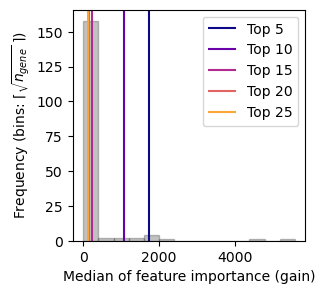

In [18]:
fig, ax = plt.subplots(figsize=(3, 3))

fi_median = fi_group.median()[
    fi_group.min() > 0
].sort_values(ascending=False)

fi_median.hist(**args(fi_median))
ylim =ax.get_ylim()

for i, v in enumerate(np.arange(5, 30, 5)):
    ax.vlines(
        fi_median.iloc[v],
        *ylim,
        color=plt.cm.plasma(i/len(np.arange(5, 30, 5))),
        label=f"Top {v}"
    )
ax.set_ylim(*ylim)
ax.legend();

ax.set(
    xlabel="Median of feature importance (gain)",
    ylabel="Frequency (bins: $\lceil\sqrt{n_{gene}}\;\\rceil$)",
    title=""
);

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/hist.png", **conf.fig_kwarg)

In [19]:
top = 15

In [20]:
gene_list = fi_group.median().sort_values(
    ascending=False
).iloc[:top].index

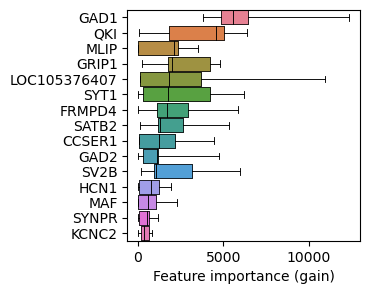

In [21]:
fig, ax = plt.subplots(figsize=(3, 3))

boxplot(
    data=fi.loc[gene_list, :].reset_index(),
    x="gain", y="genes", orient="h",
    width=0.9, whis=(0, 100), ax=ax,
    palette="husl",
    linewidth=0.5, **dict(edgecolor="k")
)

ax.set(ylabel="", xlabel="Feature importance (gain)");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/fi.png", **conf.fig_kwarg)

In [29]:
with open(f"../data/grn_features.json", mode="r") as f:
    dicts = json.load(f)

with open(f"../data/grn_features.json", mode="w") as f:
    dicts = {
        **dicts, 
        "m1_10x": gene_list.to_list()
    }
    json.dump(dicts, f)

---
## Comparison of S.D. mean and FI median

In [30]:
rank = pd.DataFrame(
    {
        "SD_mean": np.arange(len(conf.data.columns), 0, -1),
    },
    index = conf.data.columns
).loc[fi_median.index].assign(gain=fi_median)

In [31]:
rank.corr(method="spearman")

,SD_mean,gain
SD_mean,1.000000,0.310135
gain,0.310135,1.000000


/tmp/ipykernel_45226/2291892983.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rank.index, rotation=45)


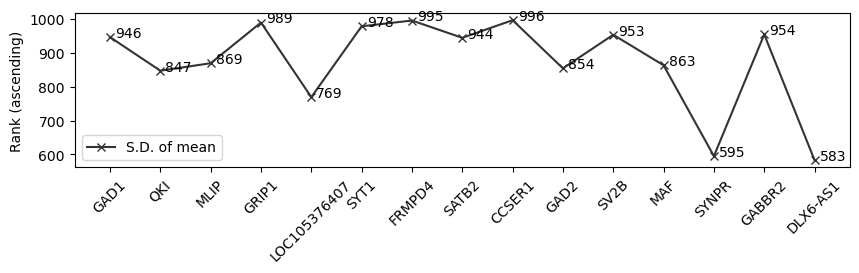

In [32]:
fig, ax = plt.subplots(figsize=(10, 2))

rank = rank.iloc[:top, :]

ax.plot(rank.index, rank.SD_mean, marker="x", label="S.D. of mean", c=".2")
# ax.plot(rank.index, rank.gain, marker="x", label="Median of FI", c="r")

for (i_sd, v_sd), (i_f, v_f) in zip(
    enumerate(rank.SD_mean.values),
    enumerate(rank.gain.values)
):
    ax.annotate(text=int(v_sd), xy=(i_sd, v_sd), xytext=(i_sd+.1, v_sd))
    # ax.annotate(text=int(v_f), xy=(i_f, v_f), xytext=(i_f, v_f+1))

ax.set_xticklabels(rank.index, rotation=45)
ax.set(ylabel="Rank (ascending)")
ax.legend(loc="lower left")

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/rank.png", **conf.fig_kwarg)

---
## Evaluation of the best model

In [33]:
tuned_model = l_model[np.argmin([v.best_score for v in l_model])].get_best_booster()

In [38]:
test_label_bin = label_binarize(
    conf.label.class_label.loc[conf.test_data.index],
    classes = [v for v in label_dict]
)

In [62]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [107]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(x_, y_, label=f"{label} (AUC:{auc.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(roc.auc)))
    
    ax[3].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c="r",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(3)})"
    )
    ax[3].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

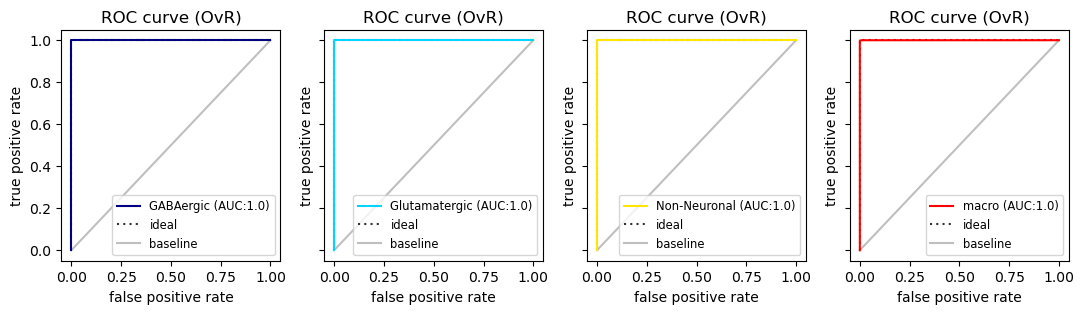

In [113]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(13, 3))

plot_roc(tuned_model, conf.test_data, test_label_bin, ax, cmap="jet", label_dict=label_dict)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/roc.png", **conf.fig_kwarg)